In [1]:
import numpy as np
import pandas as pd

import os   
import open3d as o3d
import re
import matplotlib.pyplot as plt

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
biomass = np.loadtxt("../data/biomass/biomass.txt", dtype=str)
biomass = np.array([string.replace(",", ".") for string in biomass])
biomass = biomass.astype(float)
path = "../data/biomass/biomass.npy"
np.save(path, biomass)

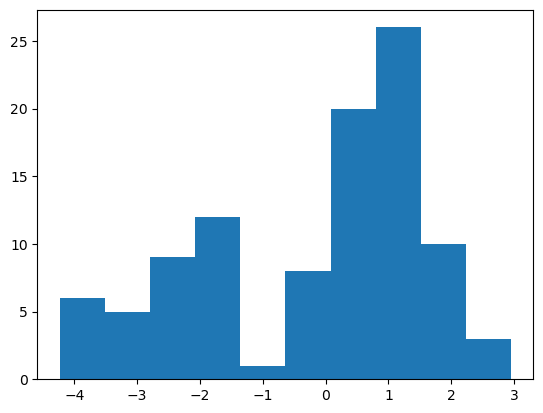

In [3]:
plt.hist(np.log(biomass), bins=10)
plt.savefig(fname="plot/biomass_hist",format="svg", bbox_inches="tight")

In [4]:
biomass = np.log(biomass)
mean_logmass = biomass.mean()
std_logmass = biomass.std()
biomass = (biomass - biomass.mean()) / biomass.std()

In [5]:
biomass.std()

1.0

In [6]:
dir = "../data/biomass/trees"
samples_list = os.listdir(dir)
sample_numbers = [re.findall(r'\d+', sample)  for sample in samples_list]
sample_numbers = [int(sample[0]) for sample in sample_numbers]
sort_idx = np.array(sample_numbers).argsort()
samples_list = [os.path.join(dir, sample) for sample in samples_list]
samples_list = np.array(samples_list)[sort_idx]

In [7]:
VAL=1000
def voxelize(points, voxelsize=0.10):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    #print(f"Voxelize the point cloud with a voxel size of {voxelsize}")
    min_bound, max_bound = np.array([-VAL, -VAL, -VAL]), np.array([VAL, VAL, VAL])
    downpcd, _, idx = pcd.voxel_down_sample_and_trace(voxelsize, min_bound, max_bound)
    print(f"Previous size: {points.shape[0]}, new size {np.asarray(downpcd.points).shape[0]}")
    return np.array(downpcd.points)

In [16]:
savedir = "../data/trees/biomass-trees"

for idx, (mass, sample) in enumerate(zip(biomass, samples_list)):
    path = os.path.join(savedir, str(idx) + ".npy")
    #if os.path.exists(path):
    #    continue
    pt = np.loadtxt(sample)
    pt = voxelize(pt)
    
    np.save(path, (mass, pt))
    #print(idx, "done")

Voxelize the point cloud with a voxel size of 0.1
Previous size: 275462, new size 43036


/user/jschnei2/miniconda3/envs/pointmae/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Voxelize the point cloud with a voxel size of 0.1
Previous size: 193131, new size 32671
Voxelize the point cloud with a voxel size of 0.1
Previous size: 107474, new size 16222
Voxelize the point cloud with a voxel size of 0.1
Previous size: 303973, new size 50123
Voxelize the point cloud with a voxel size of 0.1
Previous size: 183074, new size 29731
Voxelize the point cloud with a voxel size of 0.1
Previous size: 157271, new size 20652
Voxelize the point cloud with a voxel size of 0.1
Previous size: 182149, new size 25355
Voxelize the point cloud with a voxel size of 0.1
Previous size: 166658, new size 26176
Voxelize the point cloud with a voxel size of 0.1
Previous size: 225338, new size 32970
Voxelize the point cloud with a voxel size of 0.1
Previous size: 156709, new size 19082
Voxelize the point cloud with a voxel size of 0.1
Previous size: 309798, new size 46900
Voxelize the point cloud with a voxel size of 0.1
Previous size: 193598, new size 26095
Voxelize the point cloud with a 

# explore simple methods for prediction

In [6]:
import torch
loss = torch.nn.MSELoss()
prediction = biomass.mean()
loss(torch.tensor(prediction), torch.tensor(biomass))


/user/jschnei2/miniconda3/envs/pointmae/lib/python3.7/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.0000, dtype=torch.float64)

In [7]:
%cd ..


/srv/user/jschnei2/backup


In [8]:
import utils.parser as parser
from utils.config import *
import tools.builder as builder

argv = ["--config", "cfgs/regression/biomass_treeset.yaml"]
args = parser.get_args(argv)
config = get_config(args)
args.distributed = False
print(config.dataset.train)
config.dataset.train.others.bs = 1
config.dataset.test.others.bs = 1
config.dataset.test.others.model = config.model
config.dataset.train.others.model = config.model

INFO - 2022-11-14 10:30:10,573 - loader - Loading faiss with AVX2 support.
INFO - 2022-11-14 10:30:10,601 - loader - Successfully loaded faiss with AVX2 support.


Copy the Config file from cfgs/regression/biomass_treeset.yaml to ./experiments/regression/biomass_treeset/default/config.yaml
{'_base_': {'plot_folders': ['data/trees/biomass-trees'], 'target_type': 'biomass', 'seed': 0, 'train_ratio': 0.75, 'normalization': True, 'normalization_pars': [10, 10, 22.5], 'validate_samples': True, 'transformations': [], 'NAME': 'Cls_Treeset'}, 'others': {'subset': 'train', 'npoints': 2048}}


In [9]:
_, loader = builder.dataset_builder(args, config.dataset.train)
trainset = loader.dataset
_, loader = builder.dataset_builder(args, config.dataset.test)
testset = loader.dataset
testset.normalization=False

2022-11-14 10:30:12,279 - transfer_treesettrain - INFO - SHUFFLED THE DATA
2022-11-14 10:30:12,405 - transfer_treesettest - INFO - SHUFFLED THE DATA


3 has length 1199
4 has length 1706
6 has length 1418
15 has length 1189
16 has length 1140
20 has length 1860
27 has length 808
39 has length 1515
42 has length 1934
52 has length 1859
59 has length 1426
67 has length 1040
69 has length 1793
70 has length 889
72 has length 1185
use biomass transforms
6 has length 542
9 has length 1805
18 has length 1875
use biomass transforms


In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
from torchvision import transforms

In [11]:
trainset.transforms = transforms.Compose([])
trainset.token_transforms = transforms.Compose([])
trainset.normalization = True
testset.normalization = True

In [12]:
feat = np.empty((len(trainset), 3))
y = np.empty(len(trainset))
print(y.shape)
for i, (neighborhood, center, target) in enumerate(trainset):
    points, target = center.numpy(), target.numpy()
    ptcloud = neighborhood.reshape(-1, 3).T
    x, ys, z = ptcloud.numpy()
    feat[i, 0:3]  = np.ptp(x), np.ptp(ys) , np.ptp(z)
    y[i] = target

(75,)


In [13]:
reg = LinearRegression().fit(feat, y)
reg.score(feat, y)

0.7506845724269461

In [14]:
feattest = np.empty((len(testset), 3))
ytest = np.empty(len(testset))
for i, (neighborhood, center, target) in enumerate(testset):
    points, target = center.numpy(), target.numpy()
    ptcloud = neighborhood.reshape(-1, 3).T
    x, ys, z = ptcloud.numpy()
    feattest[i, 0:3] = np.ptp(x), np.ptp(ys) , np.ptp(z)
    ytest[i] = target


In [15]:
prediction = reg.predict(feattest)
np.mean((prediction -ytest)**2)

0.4232510681377567

# Scale up predictions to original scale

In [16]:
ytest

array([ 0.58632803,  1.76192915,  1.00357962,  1.4462682 ,  0.59812915,
       -1.85981882, -1.29188073,  0.02635864,  0.82235909, -1.7127794 ,
        1.2284025 , -1.46631074,  0.51035988,  0.30696592,  0.60433406,
        0.76335442,  0.67304122,  0.86130214,  0.11215951, -1.13843131,
        0.50172335,  0.21129139, -0.57707369,  0.98194301,  0.56444448])

In [17]:
predictions = np.load("experiments/regression/biomass_treeset/onlycenterfps/bestresultsforregression/predictions.npy").reshape(-1)
print(loss(torch.tensor(predictions), torch.tensor(ytest)))

res = (predictions - ytest)**2
res

tensor(0.1523, dtype=torch.float64)


array([1.28921355e-02, 2.66915974e-01, 2.42639784e-02, 9.94673874e-02,
       5.27544091e-02, 2.26079492e-01, 5.08835294e-04, 1.18464075e-02,
       2.80677189e-02, 1.52340911e-01, 2.04206935e-03, 5.36849191e-02,
       2.43632109e-02, 6.81614887e-02, 7.81596274e-03, 3.06121965e-02,
       8.43986873e-03, 9.66151389e-02, 1.82167785e+00, 6.29553715e-02,
       3.57755489e-05, 2.38715167e-01, 4.68705983e-01, 3.82846064e-02,
       1.04946069e-02])

In [18]:
np.sum(res) /len(res)

0.15230965863731966

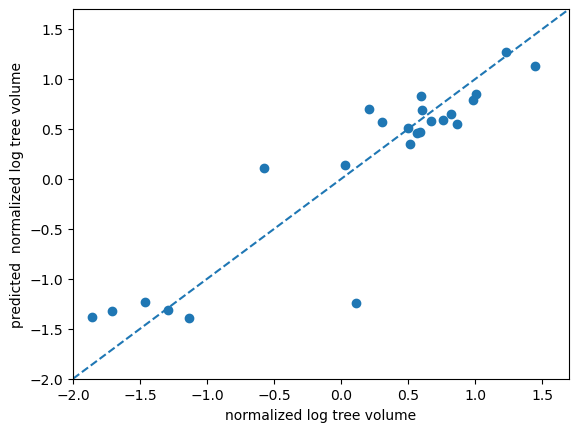

In [61]:
plt.scatter(ytest, predictions)
plt.xlabel("normalized log tree volume")
plt.xlim(-2, 1.7)
plt.ylim(-2, 1.7)
plt.ylabel("predicted  normalized log tree volume")
x1, y1 = [-2, 1.7], [-2, 1.7]
plt.plot(x1, y1, "--")
plt.savefig(fname="custom/plot/log_predvsactual.svg",format="svg", bbox_inches="tight")

In [52]:
import numpy as np
import pandas as pd
import os   
import open3d as o3d
import re

In [53]:
biomass = np.load("../data/biomass/biomass.npy")
biomass = np.log(biomass)
mean = biomass.mean()
std = biomass.std()
#biomass = (biomass - biomass.mean()) / biomass.std()

In [54]:
#rescale predictions and values to original scale
pred = np.exp(predictions * std_logmass + mean_logmass)
target = np.exp(ytest * std_logmass + mean_logmass)

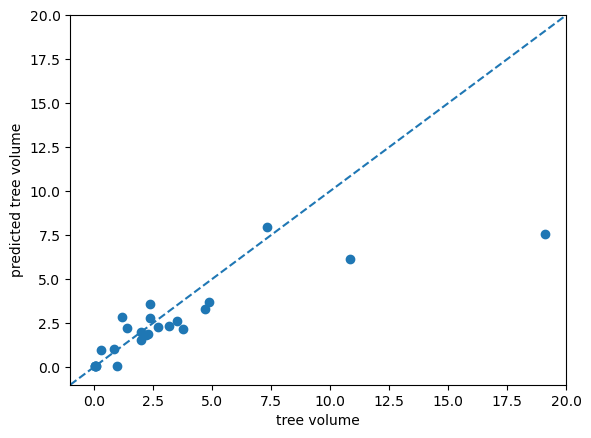

In [62]:
plt.scatter((target), (pred))
plt.xlabel("tree volume")
plt.ylabel("predicted tree volume")
plt.xlim(-1, 20)
plt.ylim(-1, 20)
x1, y1 = [-1, 20], [-1, 20]
plt.plot(x1, y1, "--")
plt.savefig(fname="custom/plot/predvsactual.svg",format="svg", bbox_inches="tight")

In [110]:
loss(torch.tensor(pred), torch.tensor(target))

tensor(6.8157, dtype=torch.float64)

In [111]:
res = (pred - target)**2
res

array([1.81413321e-01, 1.33403292e+02, 1.42296696e+00, 2.19436504e+01,
       1.45095524e+00, 1.47116360e-03, 9.81153179e-06, 3.31936866e-02,
       8.40867888e-01, 1.41508037e-03, 3.83404456e-01, 8.85857495e-04,
       2.42427334e-01, 6.99193661e-01, 1.68468822e-01, 7.32449688e-01,
       1.68454042e-01, 2.62113265e+00, 8.04067039e-01, 1.42170546e-03,
       4.58819126e-04, 2.73497906e+00, 4.76890156e-01, 1.94071341e+00,
       1.39163754e-01])

In [112]:
np.histogram(res)

(array([23,  1,  0,  0,  0,  0,  0,  0,  0,  1]),
 array([9.81153179e-06, 1.33403380e+01, 2.66806662e+01, 4.00209944e+01,
        5.33613226e+01, 6.67016509e+01, 8.00419791e+01, 9.33823073e+01,
        1.06722635e+02, 1.20062964e+02, 1.33403292e+02]))

In [113]:
np.mean(np.sort(res)[:-2])

0.6541914614765237

In [122]:
np.set_printoptions(precision=3, suppress=True)

In [130]:
np.median(res/ target)

0.12046766760630628

In [116]:
np.mean(res / target)

0.6968943868850022

In [132]:
(res/target)[np.argsort(target)]

array([0.052, 0.038, 0.015, 0.   , 0.014, 1.674, 0.039, 0.817, 2.327,
       0.501, 0.   , 0.12 , 0.063, 0.079, 0.616, 0.071, 0.062, 0.231,
       0.238, 0.693, 0.413, 0.291, 0.052, 2.027, 6.987])

In [43]:
target[np.argsort(res)]

array([ 0.07882001,  1.98138207,  0.057604  ,  0.036985  ,  0.10385801,
        0.028394  ,  0.843012  ,  2.21787412,  2.69601503,  2.38275906,
        2.30686496,  2.01238506,  7.31666211,  0.28491299,  1.39609199,
        3.17126911,  0.983607  ,  3.5261451 ,  4.88411208,  2.35632796,
        4.69778503,  3.78185116,  1.175486  , 10.82452029, 19.09222817])

In [79]:
pred

array([ 1.9069917 ,  6.5983524 ,  2.6171563 ,  7.7356563 ,  1.7866728 ,
        0.06616394,  0.07104474,  1.4559698 ,  2.3683872 ,  0.09319443,
       10.262656  ,  0.17259091,  2.6687098 ,  2.0814598 ,  2.204807  ,
        3.1815982 ,  2.4625578 ,  2.0148084 ,  0.29055193,  0.07013486,
        2.067283  ,  3.8738859 ,  0.65549564,  3.2220562 ,  1.9471403 ],
      dtype=float32)

In [80]:
target

array([ 2.30686496, 19.09222817,  4.88411208, 10.82452029,  2.35632796,
        0.028394  ,  0.07882001,  0.843012  ,  3.5261451 ,  0.036985  ,
        7.31666211,  0.057604  ,  2.01238506,  1.39609199,  2.38275906,
        3.17126911,  2.69601503,  3.78185116,  0.983607  ,  0.10385801,
        1.98138207,  1.175486  ,  0.28491299,  4.69778503,  2.21787412])